### CZ Income

August 14, 2019

Brian Dew, @bd_econ


----

Basic idea is that some places have low income but also low prices while some places have high income but housing is extremely expensive. The ACS household records have data on household income, rent, and selected owner's expenses. I calculate housing-adjusted income per household member for each commuting zone, and select a cutoff point to measure what share of each local area is below the national income distribution cutoff. 

----


To do:

- Print sample size max and min
- Speed up merge
- Add some citations and explanatory text
- Add text to map


----

Shapefile was simplified using [mapshaper](https://mapshaper.org/) to 14.0%.

In [3]:
# Import libraries and adjust settings
%matplotlib inline
import pandas as pd
import numpy as np
import os 
os.environ['PROJ_LIB'] = '/home/brian/miniconda3/share/proj'
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
acsdir = '/home/brian/Documents/ACS/'

plt.rc('font', family='Lato')

In [5]:
# Read and pre-process ACS microdata
cols = ['ST', 'PUMA', 'WGTP', 'ADJINC', 'HINCP', 
        'NP', 'ADJHSG', 'GRNTP', 'SMOCP']
dtypes = {'ST': str, 'PUMA': str}
inc_adj = lambda x: (x['ADJINC'] / 1000000) * x['HINCP']
hsg_adj = lambda x: ((x['ADJHSG'] / 1000000) * x['GRNTP'].fillna(0) + 
                     (x['ADJHSG'] / 1000000) * x['SMOCP'].fillna(0)) * 12
puma = lambda x: x['ST'] + x['PUMA']
pp_inc = lambda x: (x['INC_ADJ'] - x['HSG_ADJ']) / x['NP']
files = ['data/psam_husa_20.csv', 'data/psam_husb_20.csv']

df = pd.concat(
    [(pd.read_csv(acsdir + file, usecols=cols, dtype=dtypes)
        .query('NP > 0')
        .assign(PUMA = puma, 
                INC_ADJ = inc_adj, 
                HSG_ADJ = hsg_adj, 
                PP_INC = pp_inc))
        [['PUMA', 'WGTP', 'PP_INC']]
    for file in files]).astype({'PUMA': int})

# Calculate threshold for map
percentile = 1/3
df.sort_values('PP_INC', inplace=True)
cumsum = df.WGTP.cumsum()
cutoff = df.WGTP.sum() * percentile
cutpoint = df.PP_INC[cumsum >= cutoff].iloc[0]

print(f'Percentile {percentile * 100:.0f}: ${cutpoint:,.2f}')

Percentile 33: $15,189.01


In [7]:
# Match PUMAs to commuter zones (file from Dorn)
cz_match = pd.read_stata(acsdir + 'data/cw_puma2010_czone.dta')
cz_dict = {cz: [(puma, afactor) 
                for puma, z, afactor 
                in cz_match[cz_match['czone'] == cz].values] 
           for cz in cz_match['czone'].unique()}

d = {}
for cz, puma_list in cz_dict.items():
    pop = 0
    below_cut = 0    
    for puma, afactor in puma_list:  
        data = (df[df['PUMA'] == puma]
                  .assign(WGT = lambda x: x['WGTP'] * afactor))
        pop += data.WGT.sum()
        below_cut += data.loc[data['PP_INC'] < cutpoint, 'WGT'].sum()
        
    sh_below = below_cut / pop
    d[cz] = [sh_below, pop]
    
result = pd.DataFrame(d)
result.index = ['share', 'weight']
result = result.T

maxval = result.share.max()
minval = result.share.min()

# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.rainbow
norm = Normalize(vmin=minval, vmax=maxval)

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

pts = np.arange(1, 101, 1)
pct = (np.percentile(
    np.repeat(result.share.values, 
              result.weight.div(1000).astype(int).values), pts))

max_val = f'{maxval * 100:.1f}%'
min_val = f'{minval * 100:.1f}%'

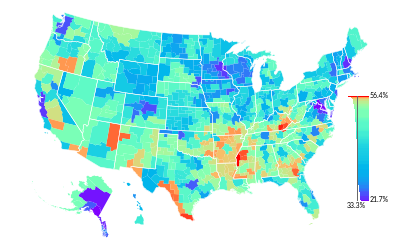

In [8]:
# Draw map
fig = plt.figure(figsize=(8.6,4.3))

m.drawmapboundary(color='white')
m.readshapefile(acsdir + 'shapefiles/cz1990', 'cz', drawbounds=False)

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    fc = cmap(norm(d[info['cz']][0]))
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
    ax.add_patch(Polygon(shape, fc=fc))

m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.5)    
    
ax.axis('off')    

ax_inset = inset_axes(ax, width='-10%', height='45%', loc=4, borderpad=4) 
for i, pt in enumerate(pct):
    rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                     fc=cmap(norm(pt)), ec=None)
    ax_inset.add_patch(rect)    

ax_inset.axvline(x=1/3, color='dimgray', zorder=1, lw=1)
ax_inset.text(1/3, -0.07, '33.3%', ha='center', fontsize=7)
ax_inset.text(-0.02, 0.98, max_val, fontsize=7)
ax_inset.text(-0.02, -0.01, min_val, fontsize=7)
ax_inset.axis('off')
plt.savefig('/home/brian/Documents/ACS/acs_map.pgf', bbox_inches='tight')